In [20]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [21]:
BATCH_SIZE = 5
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=10

In [22]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "new/images",
    seed=10,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3583 files belonging to 28 classes.


In [23]:
class_names = dataset.class_names
class_names

['0',
 '1',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [24]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(5, 224, 224, 3)
[22 17 22 23 11]


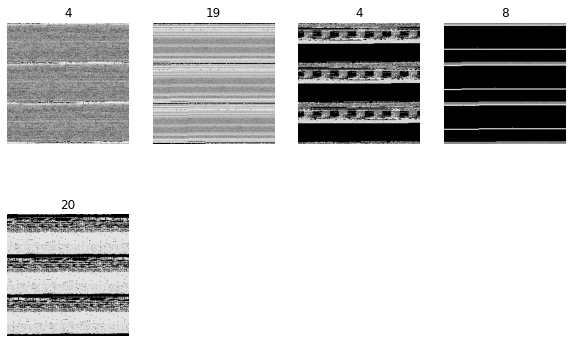

In [25]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(5):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [26]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [27]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [28]:
train_ds = train_ds.cache().shuffle(10).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(10).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(10).prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [30]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [31]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [32]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 28

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [33]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (5, 224, 224, 3)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (5, 222, 222, 32)         896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (5, 111, 111, 32)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (5, 109, 109, 64)         18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (5, 54, 54, 64)           0         
_________________________________________________________________
conv2d_5 (Conv2D)            (5, 52, 52, 64)           36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (5, 26, 26, 64)          

In [34]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [35]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
573/573 [==============================] - 77s 132ms/step - loss: 3.1036 - accuracy: 0.0912 - val_loss: 2.9370 - val_accuracy: 0.0930
Epoch 2/10
573/573 [==============================] - 77s 134ms/step - loss: 3.0391 - accuracy: 0.0877 - val_loss: 2.9290 - val_accuracy: 0.1042
Epoch 3/10
573/573 [==============================] - 76s 132ms/step - loss: 3.0355 - accuracy: 0.0884 - val_loss: 2.9269 - val_accuracy: 0.1042
Epoch 4/10
573/573 [==============================] - 80s 139ms/step - loss: 3.0351 - accuracy: 0.0873 - val_loss: 2.9217 - val_accuracy: 0.0958
Epoch 5/10
573/573 [==============================] - 85s 148ms/step - loss: 3.0357 - accuracy: 0.0845 - val_loss: 2.9283 - val_accuracy: 0.1042
Epoch 6/10
573/573 [==============================] - 90s 156ms/step - loss: 3.0340 - accuracy: 0.0884 - val_loss: 2.9262 - val_accuracy: 0.1042
Epoch 7/10
573/573 [==============================] - 84s 146ms/step - loss: 3.0330 - accuracy: 0.0901 - val_loss: 2.9293 - val_ac

In [36]:
scores = model.evaluate(test_ds)

73/73 [==============================] - 4s 33ms/step - loss: 3.0221 - accuracy: 0.0849


In [40]:
prediction = model.predict_classes(test_ds)

d:\softwares\Python\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [42]:
import numpy as np

np.savetxt('output.csv',prediction, delimiter=',', fmt='%f')